# Figure 2 Plot (Power-Curves) - CoMIGHT and Comparators

Here, we replicate the figures using pre-computed data that stores relevant metadata for all the figures.

This notebook plots the first and last dimensions with respect to each class for sets X1 and X2 that are shown as two variable sets in Figure 2 of the (Co)MIGHT paper.

In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
import math
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.metrics import roc_auc_score

from sktree.stats.utils import (
    METRIC_FUNCTIONS,
    POSITIVE_METRICS,
    POSTERIOR_FUNCTIONS,
    REGRESSOR_METRICS,
    _compute_null_distribution_coleman,
    _mutual_information,
    _non_nan_samples,
)

seed = 12345
rng = np.random.default_rng(seed)

## Test: Loading in Runs of Data

In [876]:
df = pd.read_csv(
    "./cv_comight_mv_vs_knn_vs_lr_confounder_model_pvalues_try1.csv", index_col=0
)
df = pd.read_csv(
    "./cv_comight_mv_vs_knn_vs_lr_confounder_model_varying_samples_pvalues_try1.csv",
    index_col=0,
)

df.drop(["y_true", "noise_dims", "mvrf_mi"], inplace=True, axis=1)
df.columns = df.columns.map(
    {
        "mvrf_pvalue_x2": "pvalue",
        "n_samples": "n_samples",
        "n_features_2": "n_features_2",
    }
)
display(df.head())

,pvalue,n_samples,n_features_2
0,0.071928,64,16
1,0.000999,128,16
2,0.000999,256,16
3,0.000999,512,16
4,0.000999,1024,16


In [877]:
df["pvalue"] = df["pvalue"] < 0.05

# empirical_power = (1 + (df["pvalue"] <= 0.05).sum()) / (1 + len(df["pvalue"]))
# print(empirical_power)

df = df.groupby("n_samples")["pvalue"].agg(["mean", "std"])
df.columns = df.columns.map({"mean": "pvalue", "std": "pval_std"})
df["model"] = "CoMIGHT"

display(df.head())

,pvalue,pval_std,model
n_samples,,,
64,0.73,0.446196,CoMIGHT
128,0.96,0.196946,CoMIGHT
256,1.00,0.000000,CoMIGHT
512,1.00,0.000000,CoMIGHT
1024,1.00,0.000000,CoMIGHT


In [872]:
print(df.columns)

Index(['pvalue', 'pval_std', 'model'], dtype='object')


In [873]:
print(df.shape)

(11, 3)


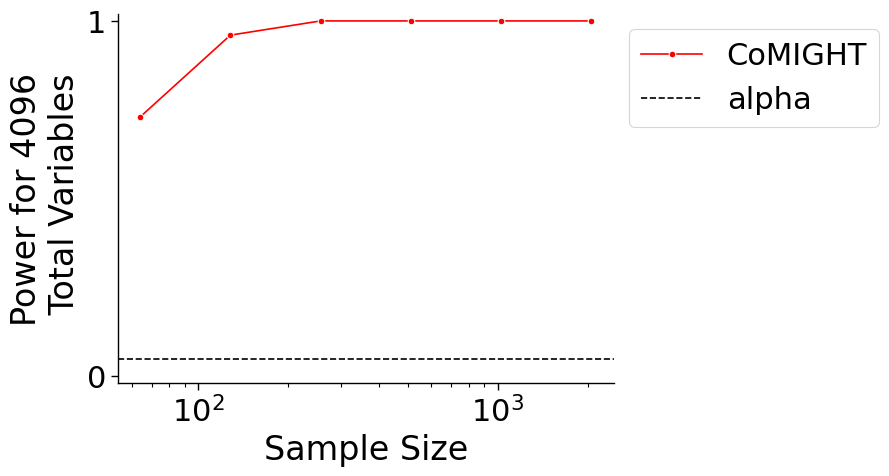

In [878]:
sns.set_context("paper", font_scale=2.5)
fig, ax = plt.subplots()

palette = {"CoMIGHT": "red", "SVM": "orange", "kNN": "green", "LR": "blue"}

ax = sns.lineplot(
    data=df,
    # x="n_features_2",
    x="n_samples",
    y="pvalue",
    marker="o",
    hue="model",
    ax=ax,
    palette=palette,
    errorbar="ci",
)

ax.set_ylabel("Power for 4096\n Total Variables")
ax.set_xlabel("Sample Size")
ax.set(
    ylim=(-0.02, 1.02),
    # ylim=[0.5, 1],
    yticks=[0, 1],
)
sns.despine(right=True, ax=ax)
ax.axhline([0.05], color="black", ls="--", label="alpha")
ax.set_xscale("log")
# ax.set_ylabel(None)
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

# Plotting the Power Curves Over Varying Sample Sizes

In [859]:
sim_type = "confounder"
metric = "mi"

In [600]:
print(sim_type)

confounder


In [601]:
n_samples = 256
n_features_2 = 2048
max_fpr = 0.1
n_repeats = 100

n_samples_list = [2**x for x in range(6, 12)]
pows = np.arange(2, 13, dtype=int)
n_features_2_list = [2**pow for pow in pows]

In [602]:
print(n_samples, n_features_2, sim_type)
print(n_samples_list)
print(n_features_2_list)

256 2048 confounder
[64, 128, 256, 512, 1024, 2048]
[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


In [603]:
def _parallel_load(idx, n_samples, n_features_2, sim_type, metric):
    results = dict()
    model = "comight"
    # model = 'cond-dcorr'
    # if sim_type == "confounder":
    #     npy_data = np.load(
    #         f"/Users/adam2392/Desktop/cancer/data/confounder/confounder_{idx}.npz"
    #     )
    # elif sim_type == "collider":
    #     npy_data = np.load(
    #         f"/Users/adam2392/Desktop/cancer/data/collider/collider_{idx}.npz"
    #     )
    # elif sim_type == "mediator":
    #     npy_data = np.load(
    #         f"/Users/adam2392/Desktop/cancer/data/mediator/mediator_{idx}.npz"
    #     )
    # elif sim_type == "direct-indirect":
    #     npy_data = np.load(
    #         f"/Users/adam2392/Desktop/cancer/data/direct-indirect/direct-indirect_{idx}.npz"
    #     )
    # elif sim_type == "independent":
    #     npy_data = np.load(
    #         f"/Users/adam2392/Desktop/cancer/data/independent/independent_{idx}.npz"
    #     )
    # X = npy_data["X"]
    # y = npy_data["y"]

    # posterior_data = np.load(
    #     f"/Users/adam2392/Desktop/cancer/cmi/{model}/{sim_type}/comight_posteriors_{n_samples}_{n_features_2}_{idx}.npz"
    # )
    posterior_data = np.load(
        f"./varying-samples/{sim_type}/comight_posteriors_{n_samples}_{n_features_2}_{idx}.npz"
    )
    samples = posterior_data["samples"]
    null_samples = posterior_data["permute_samples"]
    y = posterior_data["y_true"]
    posteriors = posterior_data["posteriors"]
    null_posteriors = posterior_data["null_posteriors"]
    # print(posteriors.shape)
    # samples = np.argwhepre(~np.isnan(np.nanmean(posteriors, axis=0)))[:, 0]
    posterior_arr = posteriors[:, samples, :]
    null_posterior_arr = null_posteriors[:, samples, :]

    # compute partial-AUC
    y_test = y[samples]

    # compute partial-AUC
    if metric == "pauc":
        observe_stat = roc_auc_score(
            y_true=y_test,
            y_score=posterior_arr.mean(axis=0),
            # max_fpr=max_fpr
        )
        permute_stat = roc_auc_score(
            y_true=y_test,
            y_score=null_posterior_arr.mean(axis=0),
            # max_fpr=max_fpr
        )
    elif metric == "mi":
        observe_stat = _mutual_information(
            y_true=y_test,
            y_pred_proba=posterior_arr.mean(axis=0),
        )
        permute_stat = _mutual_information(
            y_true=y_test,
            y_pred_proba=null_posterior_arr.mean(axis=0),
        )
    n_repeats_ = 1000

    metric_star, metric_star_pi = _compute_null_distribution_coleman(
        y_test=y[samples],
        y_pred_proba_normal=posterior_arr,
        y_pred_proba_perm=null_posterior_arr,
        metric=metric,
        n_repeats=n_repeats_,
        seed=seed,
        # max_fpr=max_fpr,
    )
    # metric^\pi - metric = observed test statistic, which under the
    # null is normally distributed around 0
    observe_test_stat = permute_stat - observe_stat

    # metric^\pi_j - metric_j, which is centered at 0
    null_dist = metric_star_pi - metric_star

    # compute pvalue
    if metric in POSITIVE_METRICS:
        pvalue = (1 + (null_dist <= observe_test_stat).sum()) / (1 + n_repeats_)
    else:
        pvalue = (1 + (null_dist >= observe_test_stat).sum()) / (1 + n_repeats_)

    results["pvalue"] = pvalue
    results["n_samples"] = n_samples
    results["n_features_2"] = n_features_2
    return results

In [559]:
print(n_samples, n_features_2)

256 2048


In [560]:
results = _parallel_load(0, n_samples, n_features_2, sim_type, metric="mi")

In [604]:
results = Parallel(n_jobs=-1)(
    delayed(_parallel_load)(idx_, n_samples_, n_features_2, sim_type, metric)
    for (idx_, n_samples_) in product(range(n_repeats), n_samples_list)
)

In [605]:
results_list = defaultdict(list)
for res in results:
    for key, val in res.items():
        results_list[key].append(val)

df = pd.DataFrame(results_list)

df["pvalue"] = df["pvalue"] < 0.05

# empirical_power = (1 + (df["pvalue"] <= 0.05).sum()) / (1 + len(df["pvalue"]))
# print(empirical_power)

df = df.groupby("n_samples")["pvalue"].agg(["mean", "std"])
df.columns = df.columns.map({"mean": "pvalue", "std": "pval_std"})
df["model"] = "CoMIGHT"

display(df.head())

,pvalue,pval_std,model
n_samples,,,
64,0.00,0.000000,CoMIGHT
128,0.04,0.196946,CoMIGHT
256,0.12,0.326599,CoMIGHT
512,0.46,0.500908,CoMIGHT
1024,0.64,0.482418,CoMIGHT


In [606]:
print(df.columns)

Index(['pvalue', 'pval_std', 'model'], dtype='object')


In [607]:
print(df.shape)

(6, 3)


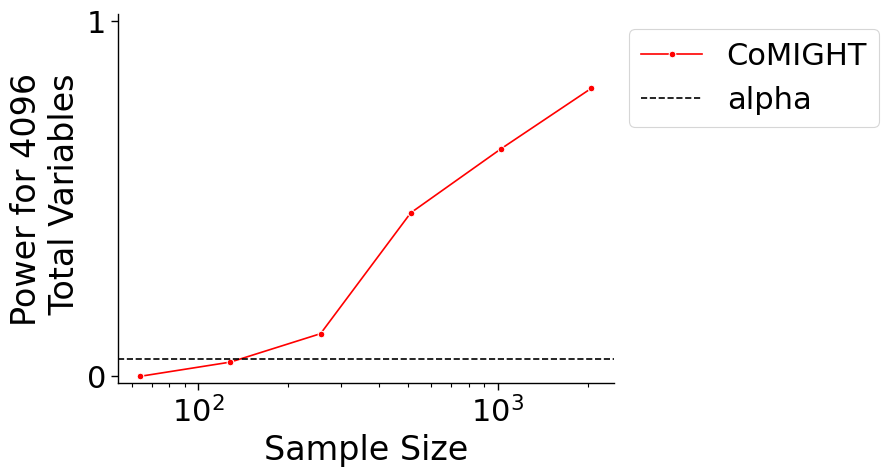

In [608]:
sns.set_context("paper", font_scale=2.5)
fig, ax = plt.subplots()

palette = {"CoMIGHT": "red", "SVM": "orange", "kNN": "green", "LR": "blue"}

ax = sns.lineplot(
    data=df,
    x="n_samples",
    y="pvalue",
    marker="o",
    hue="model",
    ax=ax,
    palette=palette,
    errorbar="ci",
)

ax.set_ylabel("Power for 4096\n Total Variables")
ax.set_xlabel("Sample Size")
ax.set(
    ylim=(-0.02, 1.02),
    # ylim=[0.5, 1],
    yticks=[0, 1],
)
sns.despine(right=True, ax=ax)
ax.axhline([0.05], color="black", ls="--", label="alpha")
ax.set_xscale("log")
# ax.set_ylabel(None)
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [609]:
print(sim_type)

confounder


In [610]:
print("done 01/06/24")

done 01/06/24


In [490]:
df.to_csv(f"./fig3_varying_samples_{sim_type}.csv")

### Make Plots from CSV

In [824]:
sim_type = "confounder"
df = pd.read_csv(f"./figures/fig3_varying_samples_{sim_type}.csv")

In [825]:
LABELS = {
    "independent": "D",
    "direct-indirect": "A",
    "confounder": "B",
    "collider": "C",
}

TITLE = {
    "independent": "Independent",
    "direct-indirect": "Linear",
    "confounder": "Logarithmic",
    "collider": "Conditionally\nIndependent",
}

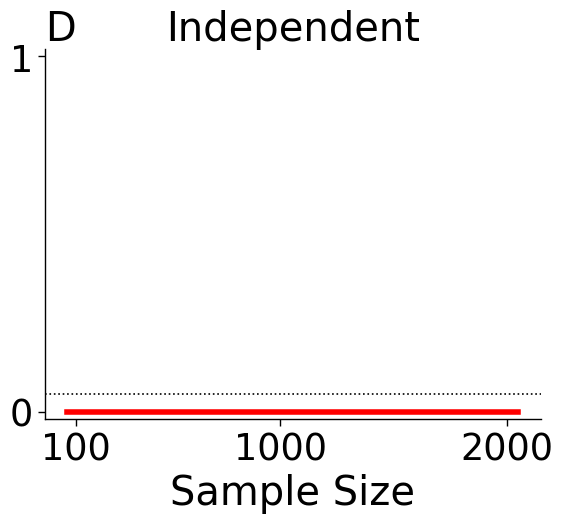

In [833]:
sns.set_context("paper", font_scale=3.0)
fig, ax = plt.subplots()

palette = {"CoMIGHT": "red", "SVM": "orange", "kNN": "green", "LR": "blue"}

ax = sns.lineplot(
    data=df,
    x="n_samples",
    y="pvalue",
    # marker="o",
    hue="model",
    ax=ax,
    palette=palette,
    errorbar="ci",
    lw=4,
    linestyle="-",
)

if sim_type == "direct-indirect":
    ax.set_ylabel("Power \nfor 4096 Variables")
else:
    ax.set_ylabel("")

ax.set_xlabel("Sample Size")
ax.set(
    ylim=(-0.02, 1.02),
    # ylim=[0.5, 1],
    yticks=[0, 1],
    # xlim=[0, 2048],
)
ax.set_xticks([100, 1000, 2000])
sns.despine(right=True, ax=ax)
ax.axhline([0.05], color="black", ls=":", label="Significance Level")
# ax.set_xscale("log")
ax.legend()
ax.set_title(LABELS[sim_type], loc="left")
ax.set_title(TITLE[sim_type])
# fig.tight_layout()

# if sim_type != "independent":
ax.get_legend().remove()
try:
    sns.move_legend(ax, "upper left", ncol=2, bbox_to_anchor=(1, 1), frameon=False)
except Exception as e:
    1 + 1
plt.show()

fig.savefig(
    f"/Users/adam2392/Desktop/cancer/figures/fig2-{LABELS[sim_type]}.svg",
    bbox_inches="tight",
)

# Plotting the Power Curves Over Dimensionality of X2

In [587]:
sim_type = "confounder"
metric = "mi"

In [588]:
print(sim_type)

collider


In [589]:
n_samples = 1024
n_features_2 = 2048
max_fpr = 0.1
n_repeats = 100

pows = np.arange(2, 13, dtype=int)
n_features_2_list = [2**pow for pow in pows]

In [590]:
print(n_samples, n_features_2, sim_type)
print(n_samples_list)
print(n_features_2_list)

1024 2048 collider
[64, 128, 256, 512, 1024, 2048]
[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


In [591]:
def _parallel_load(idx, n_samples, n_features_2, sim_type, metric):
    results = dict()
    model = "comight"
    # if sim_type == "confounder":
    #     npy_data = np.load(
    #         f"/Users/adam2392/Desktop/cancer/data/confounder/confounder_{idx}.npz"
    #     )
    # elif sim_type == "collider":
    #     npy_data = np.load(
    #         f"/Users/adam2392/Desktop/cancer/data/collider/collider_{idx}.npz"
    #     )
    # elif sim_type == "mediator":
    #     npy_data = np.load(
    #         f"/Users/adam2392/Desktop/cancer/data/mediator/mediator_{idx}.npz"
    #     )
    # elif sim_type == "direct-indirect":
    #     npy_data = np.load(
    #         f"/Users/adam2392/Desktop/cancer/data/direct-indirect/direct-indirect_{idx}.npz"
    #     )
    # elif sim_type == "independent":
    #     npy_data = np.load(
    #         f"/Users/adam2392/Desktop/cancer/data/independent/independent_{idx}.npz"
    #     )
    # X = npy_data["X"]
    # y = npy_data["y"]

    # posterior_data = np.load(
    #     f"/Users/adam2392/Desktop/cancer/varying-dimensionality/{model}/{sim_type}/comight_posteriors_{n_samples}_{n_features_2}_{idx}.npz"
    # )
    posterior_data = np.load(
        f"./varying-dimensionality/{sim_type}/comight_posteriors_{n_samples}_{n_features_2}_{idx}.npz"
    )
    samples = posterior_data["samples"]
    null_samples = posterior_data["permute_samples"]
    y = posterior_data["y_true"]
    posteriors = posterior_data["posteriors"]
    null_posteriors = posterior_data["null_posteriors"]
    # print(posteriors.shape)
    # samples = np.argwhepre(~np.isnan(np.nanmean(posteriors, axis=0)))[:, 0]
    posterior_arr = posteriors[:, samples, :]
    null_posterior_arr = null_posteriors[:, samples, :]

    # compute partial-AUC
    y_test = y[samples]

    # compute partial-AUC
    if metric == "pauc":
        observe_stat = roc_auc_score(
            y_true=y_test,
            y_score=posterior_arr.mean(axis=0),
            # max_fpr=max_fpr
        )
        permute_stat = roc_auc_score(
            y_true=y_test,
            y_score=null_posterior_arr.mean(axis=0),
            # max_fpr=max_fpr
        )
    elif metric == "mi":
        observe_stat = _mutual_information(
            y_true=y_test,
            y_pred_proba=posterior_arr.mean(axis=0),
        )
        permute_stat = _mutual_information(
            y_true=y_test,
            y_pred_proba=null_posterior_arr.mean(axis=0),
        )
    n_repeats_ = 1000

    metric_star, metric_star_pi = _compute_null_distribution_coleman(
        y_test=y[samples],
        y_pred_proba_normal=posterior_arr,
        y_pred_proba_perm=null_posterior_arr,
        metric=metric,
        n_repeats=n_repeats_,
        seed=seed,
        # max_fpr=max_fpr,
    )
    # metric^\pi - metric = observed test statistic, which under the
    # null is normally distributed around 0
    observe_test_stat = permute_stat - observe_stat

    # metric^\pi_j - metric_j, which is centered at 0
    null_dist = metric_star_pi - metric_star

    # compute pvalue
    if metric in POSITIVE_METRICS:
        pvalue = (1 + (null_dist <= observe_test_stat).sum()) / (1 + n_repeats_)
    else:
        pvalue = (1 + (null_dist >= observe_test_stat).sum()) / (1 + n_repeats_)

    results["pvalue"] = pvalue
    results["n_samples"] = n_samples
    results["n_features_2"] = n_features_2

    # now load conditional DCorr
    # cdcorr_data = np.load(
    #     f"/Users/adam2392/Desktop/cancer/pvalue/cond-dcorr/{sim_type}/conddcorr_{n_samples}_{n_features_2}_{idx}.npz"
    # )
    # cdcorr_pvalue = cdcorr_data["cdcorr_pvalue"]
    # results["cdcorr_pvalue"] = cdcorr_pvalue
    return results

In [592]:
n_samples = 1024
print(n_samples, n_features_2)

1024 2048


In [593]:
results = _parallel_load(0, n_samples, n_features_2, sim_type, metric="mi")

In [594]:
results = Parallel(n_jobs=-1)(
    delayed(_parallel_load)(idx_, n_samples, n_features_2_, sim_type, metric)
    for (idx_, n_features_2_) in product(range(n_repeats), n_features_2_list)
)

In [595]:
results_list = defaultdict(list)
for res in results:
    for key, val in res.items():
        results_list[key].append(val)

df = pd.DataFrame(results_list)

df["pvalue"] = df["pvalue"] < 0.05
df = df.groupby("n_features_2")["pvalue"].agg(["mean", "std"])
df.columns = df.columns.map({"mean": "pvalue", "std": "pval_std"})
df["model"] = "CoMIGHT"

# df["cdcorr_pvalue"] = df["cdcorr_pvalue"] < 0.05
# df = df.groupby("n_features_2")["pvalue", "cdcorr_pvalue"].agg(["mean", "std"])

# Rename the columns
# df.columns = ["_".join(col).strip() for col in df.columns.values]

# Rename mean columns to 'comight' and 'cdcorr'
# df.rename(
#     columns={"pvalue_mean": "comight", "cdcorr_pvalue_mean": "cdcorr"}, inplace=True
# )

# df = df.reset_index()
# df = pd.melt(
#     df,
#     id_vars=["n_features_2"],
#     value_vars=["comight", "cdcorr"],
#     var_name="model",
#     value_name="pvalue",
# )
# df["model"] = df["model"].map({"comight": "CoMIGHT", "cdcorr": "CondDCorr"})

display(df.head())

,pvalue,pval_std,model
n_features_2,,,
4,0.81,0.394277,CoMIGHT
8,0.90,0.301511,CoMIGHT
16,0.80,0.402015,CoMIGHT
32,0.82,0.386123,CoMIGHT
64,0.61,0.490207,CoMIGHT


In [596]:
print(df.columns)
print(sim_type)

Index(['pvalue', 'pval_std', 'model'], dtype='object')
collider


In [597]:
print(df.shape)

(11, 3)


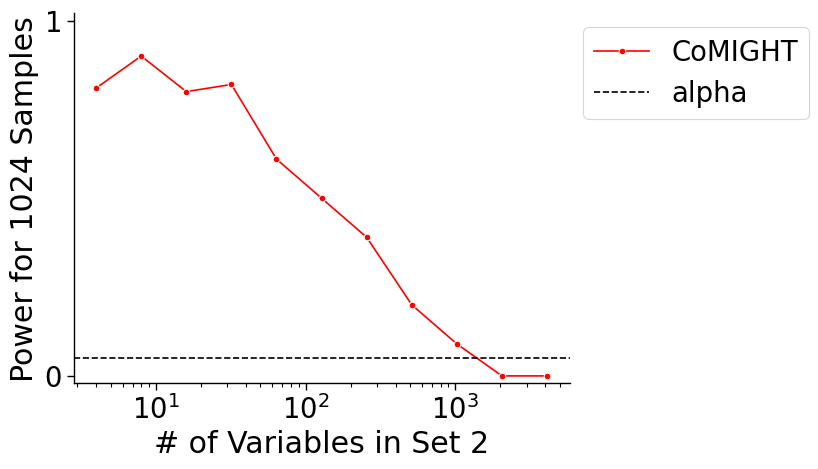

In [598]:
sns.set_context("paper", font_scale=2.25)
fig, ax = plt.subplots()

palette = {"CoMIGHT": "red", "CondDCorr": "blue"}

ax = sns.lineplot(
    data=df,
    x="n_features_2",
    y="pvalue",
    marker="o",
    hue="model",
    ax=ax,
    palette=palette,
    errorbar="ci",
)

ax.set_ylabel("Power for 1024 Samples")
ax.set_xlabel("# of Variables in Set 2")
ax.set(
    ylim=(-0.02, 1.02),
    # ylim=[0.5, 1],
    yticks=[0, 1],
    xticks=[32, 4096],
)
ax.axhline([0.05], color="black", ls="--", label="alpha")
ax.set_xscale("log")
sns.despine(right=True, ax=ax)
# ax.set_ylabel(None)
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [424]:
df.to_csv(f"./fig3_varying_dims_{sim_type}.csv")

### Make Plots from CSV

In [844]:
sim_type = "independent"
df = pd.read_csv(f"./figures/fig3_varying_dims_{sim_type}.csv")

In [845]:
LABELS = {
    "independent": "H",
    "direct-indirect": "E",
    "confounder": "F",
    "collider": "G",
}

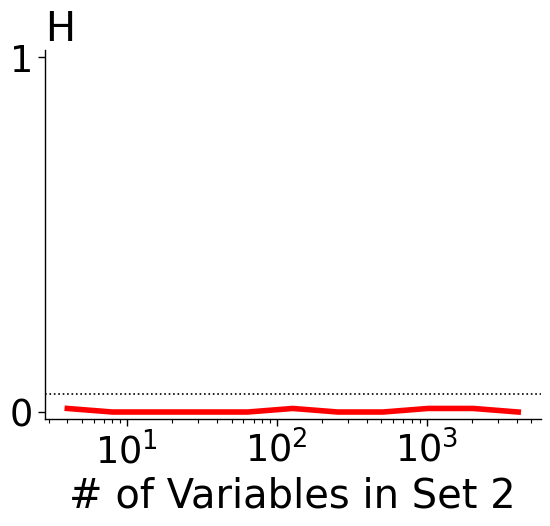

In [846]:
# sns.set_context("paper", font_scale=2.5)
fig, ax = plt.subplots()

palette = {"CoMIGHT": "red", "SVM": "orange", "kNN": "green", "LR": "blue"}

ax = sns.lineplot(
    data=df,
    x="n_features_2",
    y="pvalue",
    # marker="o",
    hue="model",
    ax=ax,
    palette=palette,
    errorbar="ci",
    lw=4,
    linestyle="-",
)

if sim_type == "direct-indirect":
    ax.set_ylabel("Power\nfor 1024 Samples")
else:
    ax.set_ylabel("")
ax.set_xlabel("# of Variables in Set 2")
ax.set(
    ylim=(-0.02, 1.02),
    yticks=[0, 1],
)
# ax.set_xticks([32, 4096])
ax.set_xscale("log")

sns.despine(right=True, ax=ax)
ax.axhline([0.05], color="black", ls=":", label="Alpha Level")
ax.legend()
ax.set_title(LABELS[sim_type], loc="left")
# fig.tight_layout()
ax.get_legend().remove()
try:
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
except Exception as e:
    1 + 1

fig.savefig(
    f"/Users/adam2392/Desktop/cancer/figures/fig2-{LABELS[sim_type]}.svg",
    bbox_inches="tight",
)

# Make Plots from CSV All Together

These are CSV files with only the necessary ingredients for plotting the power curves:

- n_features_2 or n_samples
- pvalue (in terms of MI)
- model

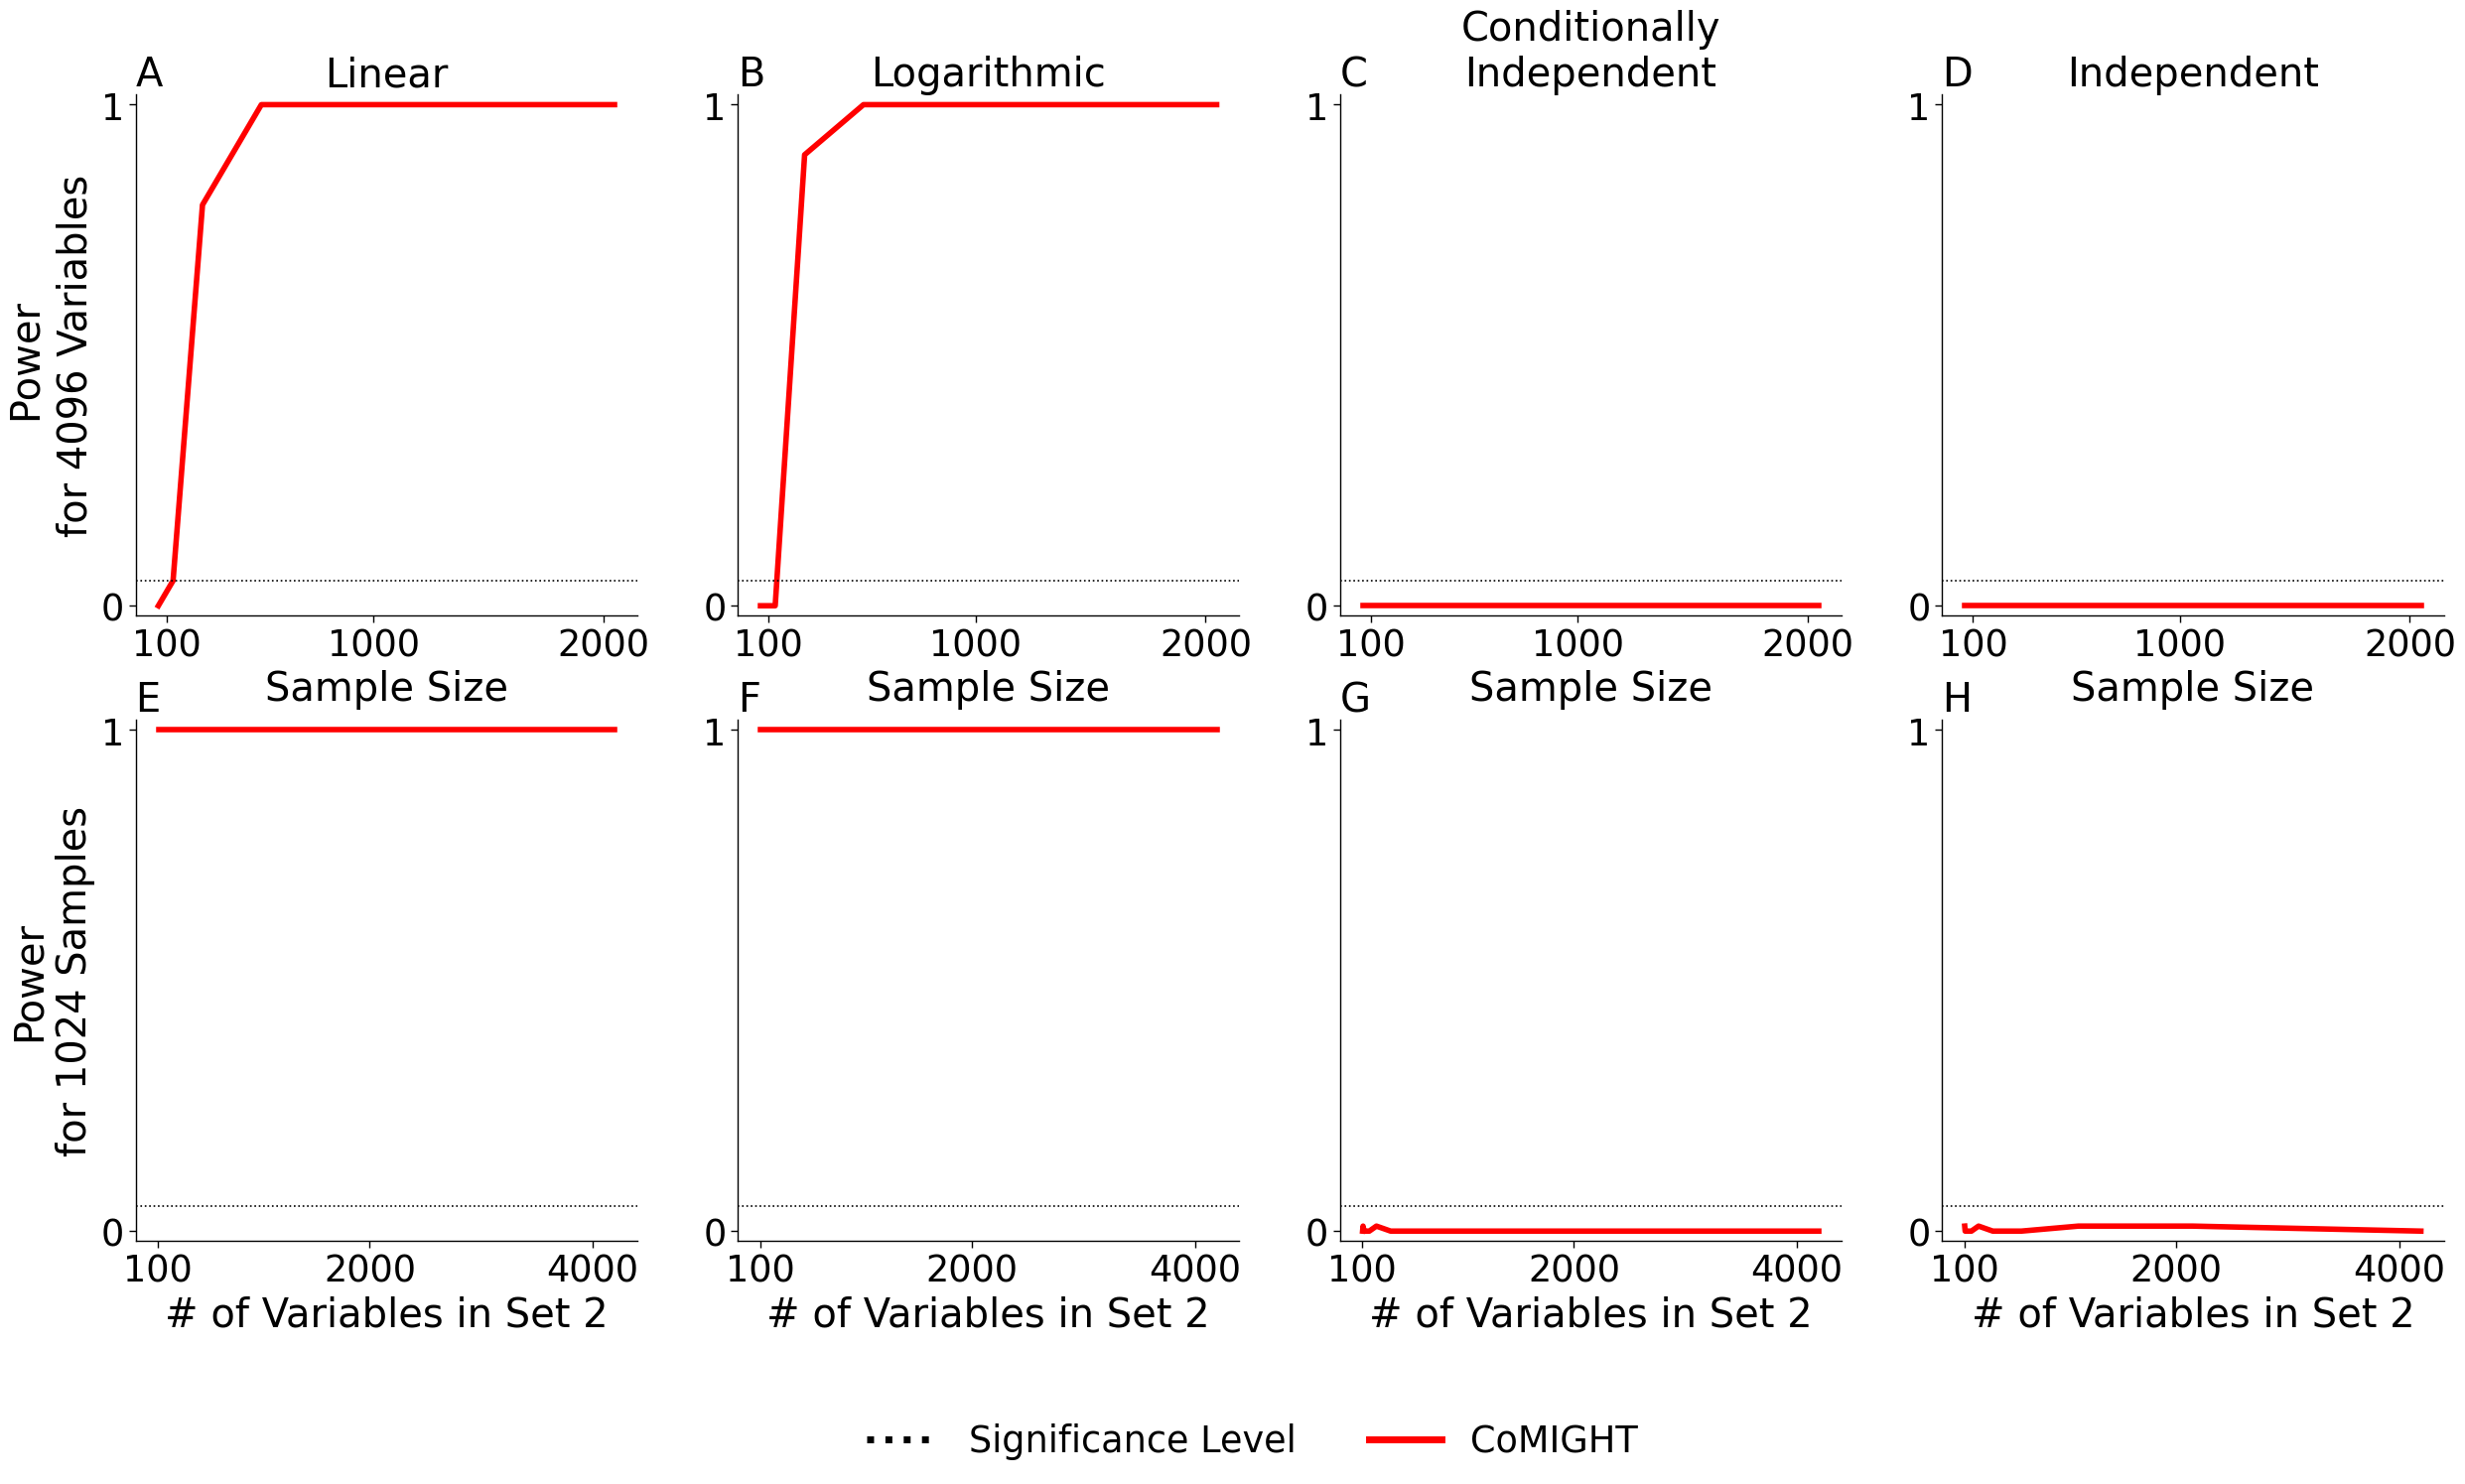

In [1008]:
sns.set_context("paper", font_scale=3.0)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(30, 15))
palette = {"CoMIGHT": "red", "SVM": "orange", "kNN": "green", "LR": "blue"}

for irow in range(2):
    if irow == 1:
        LABELS = {
            "independent": "H",
            "direct-indirect": "E",
            "confounder": "G",
            "log_collider": "F",
        }
    else:
        LABELS = {
            "independent": "D",
            "direct-indirect": "A",
            "confounder": "C",
            "log_collider": "B",
        }

        TITLE = {
            "independent": "Independent",
            "direct-indirect": "Linear",
            "confounder": "Conditionally\nIndependent",
            "log_collider": "Logarithmic",
        }
    for icol, sim_type in enumerate(
        ["direct-indirect", "log_collider", "confounder", "independent"]
    ):
        ax = axs[irow][icol]

        if irow == 1:
            df = pd.read_csv(f"/Users/adam2392/Desktop/cancer/figures/data/fig3_varying_dims_{sim_type}.csv")
            if sim_type in ["confounder", "log_collider"]:
                df["pvalue"] = df["pvalue"] < 0.05
                df = df.groupby("n_features_2")["pvalue"].agg(["mean", "std"])
                df.columns = df.columns.map({"mean": "pvalue", "std": "pval_std"})
                df["model"] = "CoMIGHT"
            ax = sns.lineplot(
                data=df,
                x="n_features_2",
                y="pvalue",
                # marker="o",
                hue="model",
                ax=ax,
                palette=palette,
                errorbar="ci",
                lw=4,
                linestyle="-",
            )

            if sim_type == "direct-indirect":
                ax.set_ylabel("Power\nfor 1024 Samples")
            else:
                ax.set_ylabel("")
            ax.set_xlabel("# of Variables in Set 2")
            ax.set(
                ylim=(-0.02, 1.02),
                yticks=[0, 1],
            )
            # ax.set_xscale("log")
            ax.set_xticks([0, 1900, 3900])
            ax.set_xticklabels([100, 2000, 4000])
            sns.despine(right=True, ax=ax)
            ax.axhline([0.05], color="black", ls=":", label="Significance Level")
            ax.legend()
            ax.set_title(LABELS[sim_type], loc="left")
            ax.get_legend().remove()
            try:
                sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
            except Exception as e:
                1 + 1
        else:
            df = pd.read_csv(f"/Users/adam2392/Desktop/cancer/figures/data/fig3_varying_samples_{sim_type}.csv")
            if sim_type in ["confounder", "log_collider"]:
                df["pvalue"] = df["pvalue"] < 0.05

                df = df.groupby("n_samples")["pvalue"].agg(["mean", "std"])
                df.columns = df.columns.map({"mean": "pvalue", "std": "pval_std"})
                df["model"] = "CoMIGHT"
            ax = sns.lineplot(
                data=df,
                x="n_samples",
                y="pvalue",
                # marker="o",
                hue="model",
                ax=ax,
                palette=palette,
                errorbar="ci",
                lw=4,
                linestyle="-",
            )

            if sim_type == "direct-indirect":
                ax.set_ylabel("Power \nfor 4096 Variables")
            else:
                ax.set_ylabel("")

            ax.set_xlabel("Sample Size")
            ax.set(
                ylim=(-0.02, 1.02),
                # ylim=[0.5, 1],
                yticks=[0, 1],
                # xlim=[0, 2048],
            )
            ax.set_xticks([100, 1000, 2000])
            # ax.set_xscale("log")
            sns.despine(right=True, ax=ax)
            ax.axhline([0.05], color="black", ls=":", label="Significance Level")
            # ax.set_xscale("log")
            ax.legend()
            ax.set_title(LABELS[sim_type], loc="left")
            ax.set_title(TITLE[sim_type])
            # fig.tight_layout()

            # if sim_type != "independent":
            ax.get_legend().remove()
            try:
                sns.move_legend(
                    ax, "upper left", ncol=2, bbox_to_anchor=(1, 1), frameon=False
                )
            except Exception as e:
                1 + 1

leg = plt.legend(
    bbox_to_anchor=(0.5, 0.01),
    bbox_transform=plt.gcf().transFigure,
    ncol=2,
    loc="upper center",
    reverse=True,
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legend_handles:
    legobj.set_linewidth(5.0)

# fig.tight_layout()
plt.show()
# fig.savefig(
#     f"/Users/adam2392/Desktop/cancer/figures/fig2whole.pdf",
#     bbox_inches="tight",
# )

## Make Plots for Post-submission tests


In [982]:
results = defaultdict(list)
model = "comight"
sim_type = "log_collider"
# sim_type = "confounder"
n_samples = 1024
n_features_2 = 4096

# for (idx, n_features_2) in product(range(n_repeats), n_features_2_list):
#     posterior_data = np.load(
#         f"/Users/adam2392/Desktop/cancer/output/varying-dimensionality/{sim_type}/comight_{n_samples}_{n_features_2}_{idx}.npz"
#     )
for (idx, n_samples) in product(range(n_repeats), n_samples_list):
    posterior_data = np.load(
        f"/Users/adam2392/Desktop/cancer/output/varying-samples/{sim_type}/comight_{n_samples}_{n_features_2}_{idx}.npz"
    )
    # samples = posterior_data["samples"]
    # null_samples = posterior_data["permute_samples"]
    # y = posterior_data["y_true"]
    pvalue = posterior_data["comight_pvalue"]

    results["pvalue"].append(pvalue)
    results["n_samples"].append(n_samples)
    results["n_features_2"].append(n_features_2)

df = pd.DataFrame(results)
display(df)
df.to_csv(f"./figures/fig3_varying_samples_{sim_type}.csv")
# df.to_csv(f"./figures/fig3_varying_dims_{sim_type}.csv")

,pvalue,n_samples,n_features_2
0,0.5864135864135864,64,4096
1,0.9470529470529471,128,4096
2,0.002997002997002997,256,4096
3,0.000999000999000999,512,4096
4,0.000999000999000999,1024,4096
...,...,...,...
595,0.8901098901098901,128,4096
596,0.001998001998001998,256,4096
597,0.000999000999000999,512,4096
598,0.000999000999000999,1024,4096


In [995]:
results = defaultdict(list)
model = "comight"
sim_type = "log_collider"
# sim_type = "confounder"
n_samples = 1024
n_features_2 = 4096

for (idx, n_features_2) in product(range(n_repeats), n_features_2_list):
    posterior_data = np.load(
        f"/Users/adam2392/Desktop/cancer/output/varying-dimensionality/{sim_type}/comight_{n_samples}_{n_features_2}_{idx}.npz"
    )
    # for (idx, n_samples) in product(range(n_repeats), n_samples_list):
    #     posterior_data = np.load(
    #         f"/Users/adam2392/Desktop/cancer/output/varying-samples/{sim_type}/comight_{n_samples}_{n_features_2}_{idx}.npz"
    #     )
    # samples = posterior_data["samples"]
    # null_samples = posterior_data["permute_samples"]
    # y = posterior_data["y_true"]
    pvalue = posterior_data["comight_pvalue"]

    results["pvalue"].append(pvalue)
    results["n_samples"].append(n_samples)
    results["n_features_2"].append(n_features_2)

In [996]:
df = pd.DataFrame(results)
df["pvalue"] = df["pvalue"] < 0.05

# empirical_power = (1 + (df["pvalue"] <= 0.05).sum()) / (1 + len(df["pvalue"]))
# print(empirical_power)

# df = df.groupby("n_samples")["pvalue"].agg(["mean", "std"])
df = df.groupby("n_features_2")["pvalue"].agg(["mean", "std"])
df.columns = df.columns.map({"mean": "pvalue", "std": "pval_std"})
df["model"] = "CoMIGHT"

display(df.head())

,pvalue,pval_std,model
n_features_2,,,
4,1.0,0.0,CoMIGHT
8,1.0,0.0,CoMIGHT
16,1.0,0.0,CoMIGHT
32,1.0,0.0,CoMIGHT
64,1.0,0.0,CoMIGHT


In [990]:
print(df.columns)

Index(['pvalue', 'pval_std', 'model'], dtype='object')


In [991]:
print(df.shape)

(6, 3)


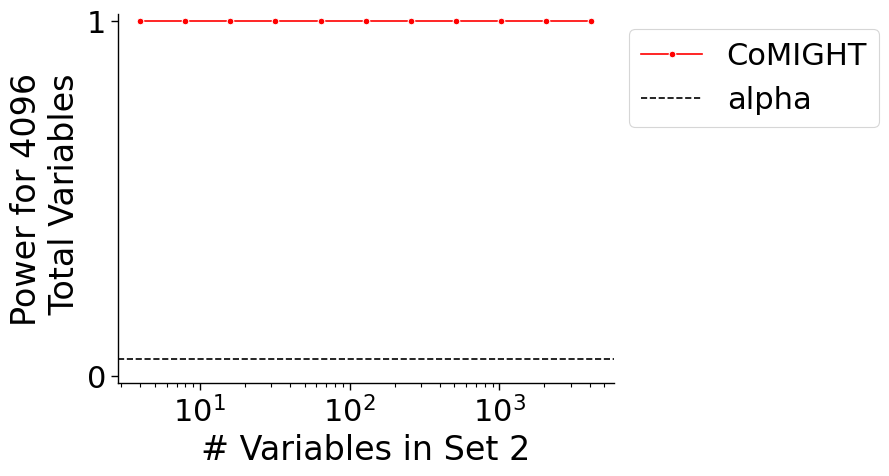

In [997]:
sns.set_context("paper", font_scale=2.5)
fig, ax = plt.subplots()

palette = {"CoMIGHT": "red", "SVM": "orange", "kNN": "green", "LR": "blue"}

ax = sns.lineplot(
    data=df,
    # x="n_samples",
    x="n_features_2",
    y="pvalue",
    marker="o",
    hue="model",
    ax=ax,
    palette=palette,
    errorbar="ci",
)

ax.set_ylabel("Power for 4096\n Total Variables")
# ax.set_xlabel("Sample Size")
ax.set_xlabel("# Variables in Set 2")
ax.set(
    ylim=(-0.02, 1.02),
    # ylim=[0.5, 1],
    yticks=[0, 1],
)
sns.despine(right=True, ax=ax)
ax.axhline([0.05], color="black", ls="--", label="alpha")
ax.set_xscale("log")
# ax.set_ylabel(None)
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()